In [1]:
import os
import urllib
from pathlib import Path

import numpy as np
import numpy.linalg as LA
import pandas as pd
import spiceypy as spice
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
from surrender.geometry import vec3, vec4, MatToQuat, gaussian
from surrender.surrender_client import surrender_client
from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import ENU_system, nadir_attitude

from craterdetection.matching.database import extract_robbins_dataset, load_craters
from craterdetection.matching.projective_invariants import crater_representation, matrix_adjugate
import craterdetection.common.constants as const
from craterdetection.common.conics import *

_BASE_URL = 'https://naif.jpl.nasa.gov/pub/naif/'
_KERNEL_ROOT = Path('../data/spice_kernels')

# Constants:
sun_radius = 696342000
earth_radius = 6371e3
ua2km = 149597870.700
ua = ua2km * 1e3
R_moon = 1737.4

In [2]:
def download_kernel(file_path, base_url=_BASE_URL, base_folder=_KERNEL_ROOT):
    if isinstance(file_path, str):
        file_path = Path(file_path)

    local_path = base_folder / file_path
    url = base_url + file_path.as_posix()

    # Create necessary sub-directories in the DL_PATH direction
    local_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        # If the file is not present in the download directory -> download it
        if not os.path.isfile(local_path):
            print(f"Downloading {url}", end="  ")
            # Download the file with the urllib  package
            urllib.request.urlretrieve(str(url), str(local_path))
            print("Done.")
        else:
            print(f"{base_folder / file_path} already exists!")
    except urllib.error.HTTPError as e:
        print(f"Error: \n{url} could not be found: ", e)

def quaternion_multiply(quaternion1, quaternion0):
    x0, y0, z0, w0 = quaternion0
    x1, y1, z1, w1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [3]:
kernels = list(map(Path, [
    'generic_kernels/lsk/naif0012.tls',
    'generic_kernels/pck/pck00010.tpc',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/spk/de421.bsp',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/pck/moon_pa_de421_1900_2050.bpc',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_assoc_pa.tf',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_080317.tf'
]))

In [4]:
for k in kernels:
    download_kernel(k)

spice.furnsh(map(str, list(map(lambda x: _KERNEL_ROOT / x, kernels))))

..\data\spice_kernels\generic_kernels\lsk\naif0012.tls already exists!
..\data\spice_kernels\generic_kernels\pck\pck00010.tpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\spk\de421.bsp already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\pck\moon_pa_de421_1900_2050.bpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_assoc_pa.tf already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_080317.tf already exists!


In [5]:
# Image setup:
fov = 45
raytracing = False
N = [2048, 2048]
rays = 64

# set PSF
surech_PSF = 5
sigma = 1
wPSF = 5
PSF = gaussian(wPSF * surech_PSF, sigma * surech_PSF)

## Initializing SurRender
s = surrender_client()
s.setVerbosityLevel(2)
s.connectToServer('127.0.0.1')
s.setCompressionLevel(0)
s.closeViewer()
s.setTimeOut(86400)
s.setShadowMapSize(4096)
s.setCubeMapSize(4096)
s.enableMultilateralFiltering(True)
s.enablePreviewMode(True)
s.enableDoublePrecisionMode(True)
s.enableRaytracing(raytracing)
s.setConventions(s.XYZ_SCALAR_CONVENTION, s.Z_FRONTWARD)
s.setPSF(PSF, wPSF, wPSF)

if raytracing:
    s.enableFastPSFMode(False)
    s.enableRaytracing(True)
    s.enableIrradianceMode(False)
    s.setNbSamplesPerPixel(rays)  # Raytracing
    s.enableRegularPSFSampling(True)
    s.enablePathTracing(False)
else:
    s.enableFastPSFMode(True)
    s.enableRaytracing(False)
    s.enableIrradianceMode(False)
    s.enablePathTracing(True)

s.setCameraFOVDeg(fov, np.arctan(np.tan(fov / 360 * np.pi) * N[1] / N[0]) * 360 / np.pi)
s.setImageSize(N[0], N[1])

s.setSunPower( ua * ua * np.pi * vec4(1, 1, 1, 1))

s.createBRDF('sun', 'sun.brdf', {})
s.createShape('sun', 'sphere.shp', {'radius': sun_radius})
s.createBody('sun', 'sun', 'sun', [])

s.createBRDF("mate", "mate.brdf", {})
s.createShape("earth_shape", "sphere.shp", {'radius': earth_radius})
s.createBody("earth", "earth_shape", "mate", ["earth.jpg"])

s.createBRDF('hapke', 'hapke.brdf', {})
s.createSphericalDEM('moon', 'Lunar_LRO_LOLA_Global_LDEM_188m_16F_PC.dem', 'hapke', 'lroc_color_poles.tiff')
s.setObjectElementBRDF('moon', 'moon', 'hapke')

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [6]:
# convert the datetime to a string, replacing the time with midnight
DATE = '2020-05-15T00:00:00'

# convert the utc midnight string to the corresponding ET
ET_DATE = spice.utc2et(DATE)

s.setObjectPosition('earth', (0, 0, 0))

SUN_POS, _ = spice.spkpos(targ='SUN', et=ET_DATE, ref='ECLIPJ2000', abcorr='NONE', obs='EARTH')
SUN_POS *= 1e3  # Convert to m
s.setObjectPosition('sun', SUN_POS)

MOON_POS, _ = spice.spkpos(targ='MOON', et=ET_DATE, ref='ECLIPJ2000', abcorr='NONE', obs='EARTH')
MOON_POS *= 1e3  # Convert to m
s.setObjectPosition('moon', MOON_POS)

print(f"Distance to Sun = {LA.norm(SUN_POS)/1e3:.0f}km\nDistance to Moon = {LA.norm(MOON_POS)/1e3:.0f}km")

Distance to Sun = 151229439km
Distance to Moon = 399289km


In [16]:
# The following extracts all craters with the given parameters and returns their lat, long, psi (angle) in radians, and
# major and minor axis in km.
lat, long, major, minor, psi, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[30, 80], ellipse_limit=1.1)
)

In [17]:
### POSITION CAMERA
height = 3000
dist = R_moon + height

p_Mi = np.array(spherical_to_cartesian(R_moon, lat, long)).T[:, :, None]
r_M = np.array(spherical_to_cartesian(dist, np.radians(0), np.radians(0)))[:, None]
dist = height / np.cos(np.radians(fov/2)*np.sqrt(2)*1.5)
visible = (np.sqrt(np.sum(np.square(p_Mi - r_M), axis=1)) < dist).ravel()
p_Mi = p_Mi[visible]
r_M

array([[4737.4],
       [   0. ],
       [   0. ]])

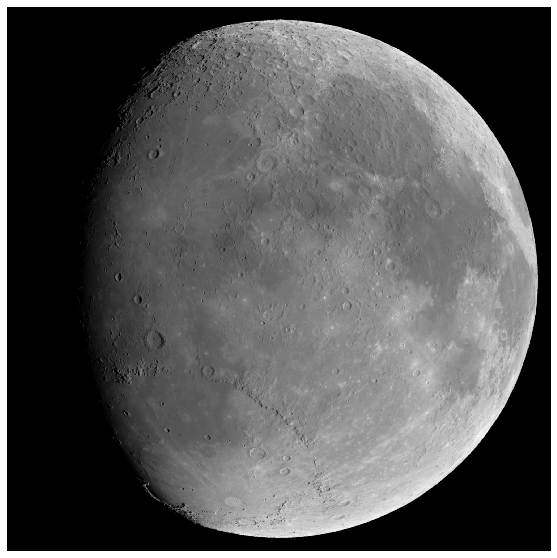

In [18]:
### ROTATE CAMERA
k = np.array([0., 0., 1.])[:, None]
CAM_POS = MOON_POS + r_M.ravel()*1e3

X_ax_cam, Y_ax_cam, Z_ax_cam = nadir_attitude(r_M)

T_CM = np.concatenate((X_ax_cam, Y_ax_cam, Z_ax_cam), axis=-1)
if LA.matrix_rank(T_CM) != 3:
    raise ValueError("Invalid camera attitude matrix!")

rot_mult = 0
s.setObjectAttitude('moon', R.from_euler('z', rot_mult*np.pi/2, degrees=False).as_quat())

s.setObjectPosition('camera', CAM_POS)
s.setObjectAttitude('camera', R.from_matrix(T_CM).as_quat())

s.render()
im = s.getImageGray32F()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, aspect='equal', interpolation='none', cmap='Greys_r', origin='upper')
ax.set_axis_off()
# fig.savefig('output/surrender_example.png')

### Mathematical Representation of a Crater
Pages 20 - 25 from [Christian, J. A., Derksen, H., & Watkins, R. (2020). Lunar Crater Identification in Digital Images](http://arxiv.org/abs/2009.01228)

#### Convert coordinates to 3D selenographic position
`load_robbins_dataset` extracts all craters with the given parameters and returns their lat, long, psi (angle) in radians, and
major and minor axis in kms.
Filter dataset using latitude & longitude limits using `latlims` and `longlims` parameters.

3D selenographic position is determined using their latitude $\varphi$ & longitude $\lambda$ along with distance
from center $\rho$:

$\rho_i \begin{bmatrix}
\cos\varphi_i\cos\lambda_i \\
\cos\varphi_i\sin\lambda_i \\
\sin\varphi_i
\end{bmatrix}$,

#### Define local ENU coordinate system per crater
$ \mathbf{u}_i = \frac{\mathbf{p}^{(c)}_{M_i}}{||\mathbf{p}^{(c)}_{M_i}||} $,
$ \mathbf{e}_i = \frac{\mathbf{k} \times \mathbf{u}_i}{|| \mathbf{k} \times \mathbf{u}_i ||} $,
$ \mathbf{n}_i = \frac{\mathbf{u}_i \times \mathbf{e}_i}{|| \mathbf{u}_i \times \mathbf{e}_i ||} $,

with $ k = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}^T $,

results in attitude transformation matrix

$ T^{E_i}_M = \begin{bmatrix} \mathbf{e}_i & \mathbf{n}_i & \mathbf{u}_i \end{bmatrix} $

In [19]:
T_EM = np.concatenate(ENU_system(p_Mi), axis=-1)

#### Define relation between point in 2D ellipse plane and 3D selenographic frame

$ H_{M_i} = \begin{bmatrix}
             T^{E_i}_M \mathbf{S} &  \mathbf{p}^{(c)}_{M_i}
           \end{bmatrix} $

$ \mathbf{S} = \begin{bmatrix}
                    \mathbf{I}_{2\times2} \\
                    \mathbf{0}_{1\times2}
                \end{bmatrix}
$

In [20]:
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)
H_Mi = np.concatenate((T_EM @ S, p_Mi), axis=-1)

### Homography and Action of a Projective Camera on a Crater Disk Quadric

#### Define camera calibration matrix

The conversion between image plane coordinates ($\mathbf{\bar{x}}_C$) and digital image pixel coordinates
($\mathbf{\bar{u}}_C$) is described the following affine transformation:

$ \mathbf{K} = \begin{bmatrix}
    d_x & \alpha & u_p \\
    0   & d_y    & v_p \\
    0   & 0      & 1
\end{bmatrix} $,

$ \mathbf{\bar{u}}_C = \mathbf{K} \mathbf{\bar{x}}_C$

In [21]:
f_x = (N[0]/2) / np.tan(np.radians(fov)/2)
f_y = (N[1]/2) / np.tan(np.radians(fov)/2)

K = np.array([[f_x, 0,       N[0]/2],
             [0,    f_y,     N[1]/2],
             [0,    0,       1]])

Using camera position in camera reference frame $C$  ($\mathbf{r }_C$) and the camera attitude $\mathbf{T}^M_C$ the camera projection matrix is as follows:

$ \mathbf{P}^M_C = \mathbf{K} \begin{bmatrix} \mathbf{T}^M_C & -r_C \end{bmatrix}$

With this, the homography to project the crater's disk quadric into its apparent ellipse in the image plane is found:

$ \mathbf{H}_{C_i} =  \mathbf{P}^M_C \begin{bmatrix}H_{M_i} \\ k^T \end{bmatrix} $

Using the [matrix representation of an ellipse](https://en.wikipedia.org/wiki/Matrix_representation_of_conic_sections)
the ellipse in the local crater plane $\mathbf{C}_i$ can be transformed to the image plane:

$ \mathbf{A_i} \propto \mathbf{H}_{C_i}^{-T} \mathbf{C}_i \mathbf{H}_{C_i}^{-1} $

In [22]:
T_MC = LA.inv(T_CM)
r_C = T_MC @ r_M
# P_MC = K @ np.concatenate((T_MC, -r_C), axis=1)
P_MC = K @ T_MC @ np.concatenate((np.identity(3), -r_M), axis=1)
H_Ci = P_MC @ np.concatenate((H_Mi, np.tile(k.T[None, ...], (len(H_Mi), 1, 1))), axis=1)

C_i = crater_representation(major[visible], minor[visible], psi[visible])
A_i =  LA.inv(H_Ci).transpose((0, 2, 1)) @ C_i @ LA.inv(H_Ci)

#### Overlay output onto render

In [23]:
# ax.set_axis_off()
# fig.savefig('output/demonax_overlaid.png')

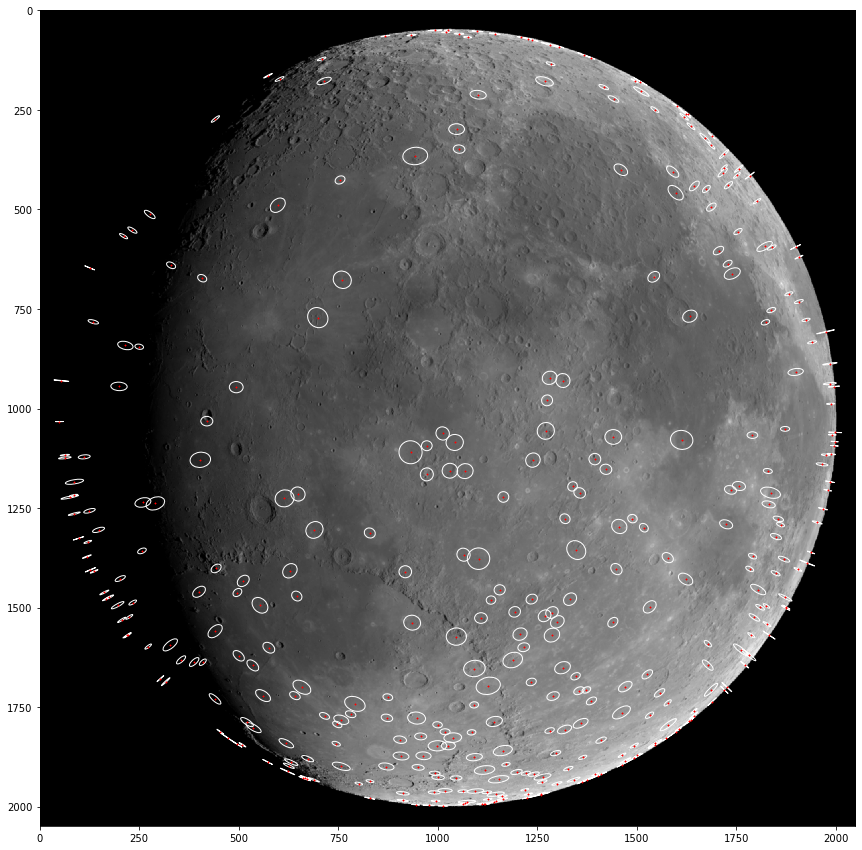

In [29]:
cam = Camera(r_M, T_CM, fov=fov, resolution=N)
a_proj, b_proj = ellipse_axes(scale_det(A_i))
psi_proj = ellipse_angle(scale_det(A_i))
r_pix_proj = conic_center(scale_det(A_i))

swap = b_proj > a_proj
a_proj[swap], b_proj[swap] = b_proj[swap], a_proj[swap]

from matplotlib.collections import EllipseCollection
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
ax.imshow(im, aspect='equal', interpolation='none', cmap='gray')
ec = EllipseCollection(a_proj, b_proj, np.degrees(psi_proj), units='xy', offsets=r_pix_proj,
                       transOffset=ax.transData, facecolors="None", edgecolors='w')
ax.add_collection(ec)
ax.scatter(*cam.project_crater_centers(p_Mi).T, c='r', s=0.8, marker='x')

ax.set_xlim(0, N[0])
ax.set_ylim(N[1], 0)

plt.show()

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


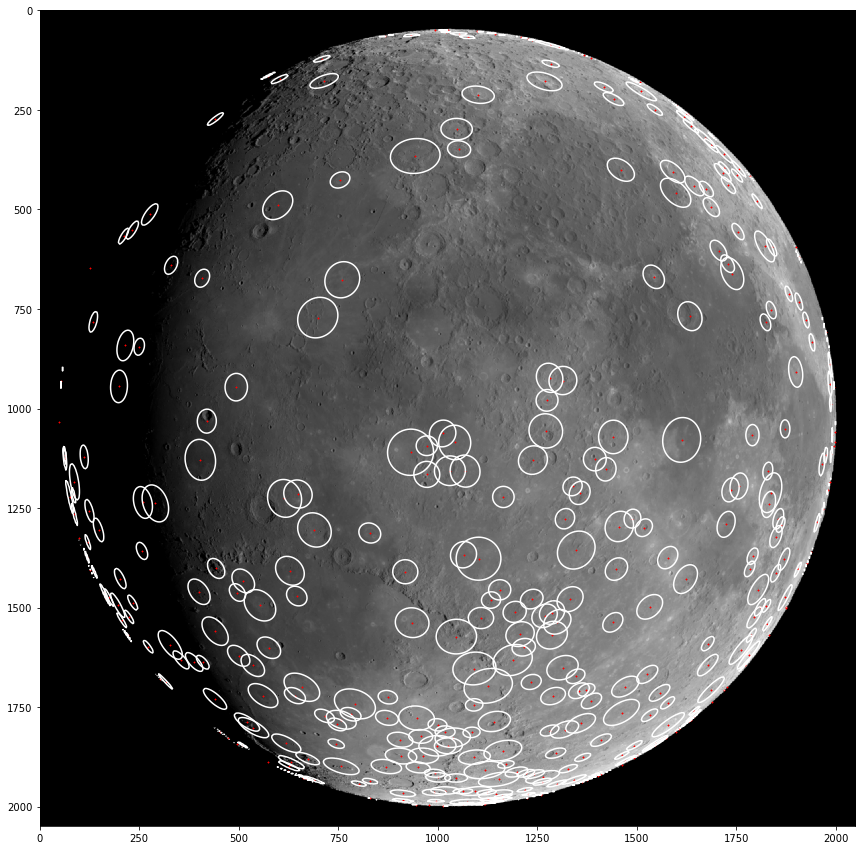

In [30]:
x_plot = np.linspace(0, N[0], 500)
y_plot = np.linspace(0, N[1], 500)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

crater_centers = (H_Ci @ np.array([0, 0, 1]) / (H_Ci @ np.array([0, 0, 1]))[:, -1][:, None])[:, :2]
# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.imshow(im, aspect='equal', interpolation='none', cmap='gray')
ax.set_xlim(0, N[0])
ax.set_ylim(N[1], 0)

for a_i in A_i:
    c = xy_homogeneous.transpose(0, 2, 1) @ a_i @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors='w')
ax.scatter(*crater_centers.T, c='r', s=0.8, marker='x')